# Problem Set 2

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS, FamaMacBeth

### Question 1: Fixed Effects And Within Transformations

#### 1). Regress fuel efficiency (city.mpg) on horsepower without fixed effects. What should you conclude based on that regression?

In [52]:
carData = pd.read_csv('imports85_modified.csv')
carData = carData[carData["horsepower"].notna()]
carData = carData[carData["city.mpg"].notna()]

horsepower = carData[["horsepower"]]
horsepower = sm.add_constant(horsepower)
efficiency = carData[["city.mpg"]]

regressionHorsepower = sm.OLS(efficiency, horsepower).fit()
print(regressionHorsepower.summary())

                            OLS Regression Results                            
Dep. Variable:               city.mpg   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.25
Date:                Sun, 13 Apr 2025   Prob (F-statistic):            0.00159
Time:                        20:29:01   Log-Likelihood:                -689.24
No. Observations:                 203   AIC:                             1382.
Df Residuals:                     201   BIC:                             1389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2295      1.433      8.534      0.0

This regression implies that when car efficiency goes up, so does horsepower. This regression looks only at all of the horsepower and car efficiency without other distinguishing features.

#### 2). Repeat the same regression but this time, add a fixed effect for the number of cylinders being equal to "two" or "four" (code this as a "1" and any other value as a zero). What would you conclude based on this new regression? What do you think drives the results in part 1?

In [53]:
carData = carData.rename(columns={"city.mpg": "city_mpg"})
carData["cylinder"] = carData["num.of.cylinders"].isin(["two", "four"]).astype(int)
carData = carData.set_index(["make", carData.index])

In [54]:
model = PanelOLS.from_formula("city_mpg ~ horsepower + cylinder + EntityEffects", data=carData)
results = model.fit()

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               city_mpg   R-squared:                        0.8190
Estimator:                   PanelOLS   R-squared (Between):             -5.1291
No. Observations:                 203   R-squared (Within):               0.8190
Date:                Sun, Apr 13 2025   R-squared (Overall):             -5.3111
Time:                        20:29:01   Log-likelihood                   -463.78
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      407.10
Entities:                          21   P-value                           0.0000
Avg Obs:                       9.6667   Distribution:                   F(2,180)
Min Obs:                       1.0000                                           
Max Obs:                       32.000   F-statistic (robust):             407.10
                            

Based on this new regression that factors in the fixed effects, we see that the coefficent for horsepower is negative now, although slightly, and theres a very large negative coefficient for the cylinder fixed effect we added. This helps us better understand that more cylinders in a car corresponds to lower car efficiency.

#### 3). (Within transformation) Now obtain the mean city.mpg and horsepower for each group. Use these group means to demean horsepower and city.mph. Run the same regression you ran in part 1. Are these results different? Are the results obtained here different from the results in part 2? What does this tell you about the relation between fixed effect regressions and within transformations?

### Question 2: On Marginal Significance and Trading Strategy Improvements

#### You come up with a signal of stock outperformance: log total asset growth. You realize that your professor has conveniently already coded up this variable for you in the dataset StockRetAcct_DT.csv. The variable is called "lnInv".

#### 1). Using the Fama-MacBeth regression approach, what are the average return, standard deviation, and Sharpe ratio of the trading strategy implied by using only an intercept and lnInv on the right hand side in the regressions?

In [55]:
returnsDF = pd.read_csv("StockRetAcct_DT.csv")
returnsDF = returnsDF[returnsDF["lnInv"].notna()]
returnsDF["ExRet"]=np.exp(returnsDF.lnAnnRet)- np.exp(returnsDF.lnRf)

returnsDF = returnsDF.set_index(["FirmID", "year"])
y, X  = dmatrices("ExRet~lnInv", returnsDF, return_type = "dataframe")

res1 = FamaMacBeth(y, X).fit()
FamaMacBeth(y,X).fit()

Dep. Variable:,ExRet,R-squared:,0.0073
Estimator:,FamaMacBeth,R-squared (Between):,-0.0146
No. Observations:,66788,R-squared (Within):,0.0045
Date:,"Sun, Apr 13 2025",R-squared (Overall):,0.0073
Time:,20:29:02,Log-likelihood,-4.547e+04
Cov. Estimator:,Fama-MacBeth Standard Cov,,
,,F-statistic:,493.90
Entities:,7694,P-value,0.0000
Avg Obs:,8.6805,Distribution:,"F(1,66786)"
Min Obs:,1.0000,,
Max Obs:,35.000,F-statistic (robust):,11.932


In [56]:
averageReturns1 = res1.params.mean()
standardDeviation1 = res1.std_errors.mean()

sharpeRatio1 = averageReturns1 / standardDeviation1

print("Average Return: ", round(averageReturns1, 4))
print("Standard Error: ", round(standardDeviation1,4))
print("Sharpe Ratio: ", round(sharpeRatio1,4))

Average Return:  0.0105
Standard Error:  0.028
Sharpe Ratio:  0.3744


#### 2). What is the analytical expression for the portfolio weights in this case? (Formula)

#### From the lecture notes, we know that the formula for the portfolio weights is $\lambda_{1,,t} = \sum_{i=1}^{N} \frac{1}{N}\frac{(x_{i,t-1}-E_n[x_{i, t-1}])}{Var_N[x_{i, t-1}]} R_{i, t}$

#### Then we can just fill in our regression variable in the $w_{i, t-1} = \frac{1}{N} \frac{(x_{i,t-1}-E_n[x_{i, t-1}])}{Var_N[x_{i, t-1}]} $ formula

#### Thus, our expression for the portfolio weights in this case are $w_{i, t-1} = \frac{1}{N} \frac{(lnInv_{i, t-1}- E_n[lnInv_{i, t-1}])}{Var_N[lnInv_{i, t-1}]} $ formula

#### However, the expected value is just the mean, so we simplify this into $w_{i, t-1} = \frac{1}{N} \frac{(x_{i,t-1}- mean[x_{i, t-1}])}{Var_N[x_{i, t-1}]} $.

#### 3). You worry that there is industry-related noise associated with the characteristic lnInv and want to clean up your trading strategy with the goal of reducing exponsure to unpriced industry risks. What regressions to you run? Report mean, standard deviation, and Sharpe Ratio of the 'cleaned-up' trading strategy.

In [57]:
returnsDF['Industry']=returnsDF['ff_ind'].astype(object)
y, X  = dmatrices("ExRet~lnInv+Industry", returnsDF, return_type = "dataframe")

res2 = FamaMacBeth(y, X).fit()
FamaMacBeth(y,X).fit()

Dep. Variable:,ExRet,R-squared:,0.0078
Estimator:,FamaMacBeth,R-squared (Between):,-0.0260
No. Observations:,66783,R-squared (Within):,0.0043
Date:,"Sun, Apr 13 2025",R-squared (Overall):,0.0078
Time:,20:29:03,Log-likelihood,-4.543e+04
Cov. Estimator:,Fama-MacBeth Standard Cov,,
,,F-statistic:,43.789
Entities:,7694,P-value,0.0000
Avg Obs:,8.6799,Distribution:,"F(12,66770)"
Min Obs:,1.0000,,
Max Obs:,35.000,F-statistic (robust):,6.4579


In [58]:
averageReturns2 = res2.params.mean()
standardDeviation2 = res2.std_errors.mean()

sharpeRatio2 = averageReturns2 / standardDeviation2

print("Average Return: ", round(averageReturns2, 4))
print("Standard Error: ", round(standardDeviation2,4))
print("Sharpe Ratio: ", round(sharpeRatio2,4))

Average Return:  0.0007
Standard Error:  0.0271
Sharpe Ratio:  0.0254


#### 4). As in the class notes, plot the cumulative returns to the simple and the 'cleaned-up' trading strategies based on your new signal, lnInv. Make sure both trading strategies result in portfolios with a 15% return standard deviation.

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Cumulative Return'),
 Text(0.5, 1.0, 'Old Value vs New Value')]

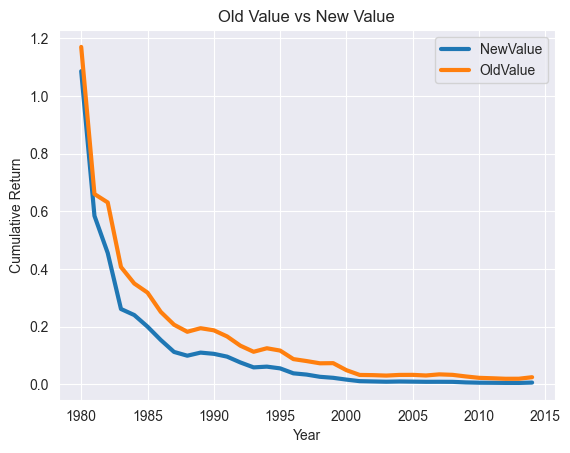

In [69]:
y, X  = dmatrices("ExRet~lnInv+Industry", returnsDF, return_type = "dataframe")
res = FamaMacBeth(y,X).fit()

lnInvstdev = res.all_params.lnInv.std()
lnInvret = res.all_params.lnInv
lnInv_ret = lnInvret*0.15/lnInvstdev
cum_ret_lnInv = pd.DataFrame.cumsum(np.log(1+lnInv_ret))

lnInvstdev = res1.all_params.lnInv.std()
lnInvret = res1.all_params.lnInv
lnInv_old_ret = pd.DataFrame.cumsum(np.log(1+lnInvret*0.15/lnInvstdev))

summary = pd.DataFrame()
summary['NewValue'] = np.exp(cum_ret_lnInv)
summary['OldValue'] = np.exp(lnInv_old_ret)

sns.set_style('darkgrid')
plt.figure()
ax=sns.lineplot(data=summary,dashes = False,linewidth = 3)
ax.set(xlabel = 'Year',
ylabel = 'Cumulative Return',
title = "Old Value vs New Value")